In [1]:
%load_ext autoreload
%autoreload 2

## Investigating greedy decoding

In [2]:
import wandb
import torch

from Encoder import EncoderRNN
from Decoder import DecoderRNN

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [4]:
wandb.login()
api = wandb.Api()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lukasm. Use `wandb login --relogin` to force relogin


In [5]:
from Dataloader import Dataloader, get_dataset_path

dataloader = Dataloader()

train_path = get_dataset_path('SCAN/length_split', 'length', 'train')
train_X, train_Y = dataloader.fit_transform(train_path)
test_path = get_dataset_path('SCAN/length_split', 'length', 'test')
test_X, test_Y = dataloader.transform(test_path)

In [6]:
import yaml

def load_model(run):
    print(f'getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/{run}')
    run_path = f'project-group-1/Paper-Implemenation/{run}'
    run = api.run(run_path)
    files = run.files()

    for file in files:
        file.download(replace=True, root=f'./saved_models/{run}')

    with open(f'./saved_models/{run}/config.yaml', 'r') as f:
        config = yaml.safe_load(f.read())

    rnn_type = config['rnn-type']['value']
    input_size = config['input_size']['value']
    output_size = config['output_size']['value']
    hidden_size = config['hidden_units']['value']
    hidden_layers = config['layers']['value']
    dropout = config['dropout']['value']
    attention = config['attention']['value']

    print(
        f'model: rnn_type={rnn_type}, input_size={input_size}, output_size={output_size}, '
        f'hidden_size={hidden_size}, hiddel_layers={hidden_layers},'
        f'dropout={dropout}, attention={attention}'
    )

    encoder = EncoderRNN(
        RNN_type=rnn_type,
        input_size=input_size,
        hidden_size=hidden_size,
        hidden_layers=hidden_layers,
        dropout=dropout
    )
    encoder.load_state_dict(torch.load(f'saved_models/{run}/encoder.pt'))
    encoder.to(device)
    encoder.eval()

    decoder = DecoderRNN(
        RNN_type=rnn_type,
        input_size=hidden_size,
        output_size=output_size,
        hidden_size=hidden_size,
        hidden_layers=hidden_layers,
        dropout=dropout,
        attention=attention
    )
    decoder.load_state_dict(torch.load(f'saved_models/{run}/decoder.pt'))
    decoder.to(device)
    decoder.eval()

    return encoder, decoder

In [7]:
from Lang import Lang

def encode(encoder, commands):
    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(commands.shape[0], encoder.hidden_size, device=device)

    for idx, command in enumerate(commands):
        encoder_output, encoder_hidden = encoder(command, encoder_hidden)
        encoder_outputs[idx] = encoder_output[0, 0]

    return encoder_hidden, encoder_outputs

def score_actions(encoder, decoder, commands, gold_actions, teacher_forcing=False):
    with torch.no_grad():
        encoder_hidden, encoder_outputs = encode(encoder, commands)

        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor(Lang.SOS_token, dtype=torch.long, device=device)
        decoder_outputs = torch.zeros(gold_actions.shape[0], dtype=torch.long, device=device)

        total_score = 0
        for idx, gold_action in enumerate(gold_actions):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

            action = gold_action[0] if teacher_forcing else decoder_output.argmax().detach()
            score = decoder_output[0, action].detach().item()
            total_score += score

            decoder_outputs[idx] = action

            if not teacher_forcing and action == Lang.EOS_token:
                break

            decoder_input = action

        return decoder_outputs, total_score

In [8]:
import pandas as pd

def get_errors_df(encoder, decoder):
    error_results = []
    for idx, (commands, gold_actions) in enumerate(zip(test_X, test_Y)):
        actions, score = score_actions(encoder, decoder, commands, gold_actions)

        if not torch.equal(actions, gold_actions.view(1, -1)[0]):
            _, gold_score = score_actions(encoder, decoder, commands, gold_actions, teacher_forcing=True)
            error_results.append((idx, commands.shape[0], torch.count_nonzero(actions).item(), gold_actions.shape[0], score, gold_score))

    return pd.DataFrame(error_results, columns=['idx', 'commands', 'pred_actions', 'gold_actions', 'pred_score', 'gold_score'])

In [9]:
def collect_error_data(runs):
    dfs = []
    for run, kind in runs:
        encoder, decoder = load_model(run)

        print(f'collecting error data for {run} ({kind})')
        errors_df = get_errors_df(encoder, decoder)
        errors_df['run'] = run
        errors_df['kind'] = kind
        dfs.append(errors_df)

    return pd.concat(dfs)

In [10]:
runs = [
    ('165ia2vw', 'length-best'),
    ('2kfyfqfm', 'length-best'),
    ('13hjlp4s', 'length-best'),

    ('8l8heh1g', 'overall-best'),
    ('biap89fa', 'overall-best'),
    ('2zykyqzr', 'overall-best'),
]
errors_df = collect_error_data(runs)

getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/165ia2vw
model: rnn_type=GRU, input_size=15, output_size=8, hidden_size=50, hiddel_layers=1,dropout=0.5, attention=True


/home/lukasm/code/Advanced-NLP-Paper-Implementation/venv/lib64/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


collecting error data for 165ia2vw (length-best)
getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/2kfyfqfm
model: rnn_type=GRU, input_size=15, output_size=8, hidden_size=50, hiddel_layers=1,dropout=0.5, attention=True
collecting error data for 2kfyfqfm (length-best)


/home/lukasm/code/Advanced-NLP-Paper-Implementation/venv/lib64/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/13hjlp4s
model: rnn_type=GRU, input_size=15, output_size=8, hidden_size=50, hiddel_layers=1,dropout=0.5, attention=True
collecting error data for 13hjlp4s (length-best)


/home/lukasm/code/Advanced-NLP-Paper-Implementation/venv/lib64/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/8l8heh1g
model: rnn_type=LSTM, input_size=15, output_size=8, hidden_size=200, hiddel_layers=2,dropout=0.5, attention=False
collecting error data for 8l8heh1g (overall-best)
getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/biap89fa
model: rnn_type=LSTM, input_size=15, output_size=8, hidden_size=200, hiddel_layers=2,dropout=0.5, attention=False
collecting error data for biap89fa (overall-best)
getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/2zykyqzr
model: rnn_type=LSTM, input_size=15, output_size=8, hidden_size=200, hiddel_layers=2,dropout=0.5, attention=False
collecting error data for 2zykyqzr (overall-best)


In [11]:
errors_df[:10]

,idx,commands,pred_actions,gold_actions,pred_score,gold_score,run,kind
0,0,9,21,25,-0.381958,-1.595276,165ia2vw,length-best
1,4,9,21,25,-0.132055,-2.540771,165ia2vw,length-best
2,10,10,21,25,-0.228069,-2.499012,165ia2vw,length-best
3,11,10,21,25,-1.600328,-5.868978,165ia2vw,length-best
4,12,10,21,25,-0.388223,-2.729990,165ia2vw,length-best
5,15,9,21,25,-0.593653,-1.353943,165ia2vw,length-best
6,22,10,21,25,-0.134163,-2.796153,165ia2vw,length-best
7,23,10,21,25,-0.154477,-2.820054,165ia2vw,length-best
8,25,10,21,25,-0.618450,-1.086645,165ia2vw,length-best
9,27,10,21,25,-0.467228,-1.752602,165ia2vw,length-best


In [12]:
# No examples where gold sequence was more likely that the predicted (greedy) sequence
errors_df[errors_df['gold_score'] > errors_df['pred_score']]

,idx,commands,pred_actions,gold_actions,pred_score,gold_score,run,kind


In [13]:
import numpy as np

errors_df\
    .groupby(['commands', 'kind'])['pred_actions', 'gold_actions', 'pred_score', 'gold_score']\
    .agg({'pred_actions': [np.mean], 'gold_actions': [np.mean], 'pred_score': [np.mean], 'gold_score': [np.mean]})

/tmp/ipykernel_774279/1203592586.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  errors_df\


pred_actions gold_actions pred_score  gold_score
                              mean         mean       mean        mean
commands kind                                                         
5        length-best     23.350000    25.000000  -2.581688 -104.542457
         overall-best    17.375000    25.000000  -0.145458  -42.148958
7        length-best     22.622396    26.000000  -2.234698  -89.757337
         overall-best    18.052083    26.000000  -0.027053  -62.175669
8        length-best     22.953461    27.112275  -2.324665 -100.589481
         overall-best    19.172454    27.111111  -0.026101  -65.182991
9        length-best     25.157743    29.369748  -2.686423 -121.542991
         overall-best    21.857811    29.741357  -0.045718  -65.568591
10       length-best     29.708061    34.454053  -2.580476 -144.785450
         overall-best    26.825380    35.654693  -0.098439  -75.678247

## Investigating model behaviour when teacher forcing golden actions

In [324]:
def get_ranking(decoder_output, gold_action):
    pairs = []
    for action, logit in enumerate(decoder_output[0]):
        pairs.append((action, logit.item()))

    action_rankings, action_scores = zip(*sorted(pairs, key=lambda p: p[1], reverse=True))

    rank = action_rankings.index(gold_action)
    score = action_scores[rank]
    pred_action = action_rankings[0]

    return rank, score, pred_action


def rank_gold_actions(encoder, decoder, commands, gold_actions):
    with torch.no_grad():
        encoder_hidden, encoder_outputs = encode(encoder, commands)

        decoder_hidden = encoder_hidden
        decoder_input = torch.tensor(Lang.SOS_token, dtype=torch.long, device=device)

        ranks = []
        total_score = 0
        pred_actions = []
        for idx, gold_action in enumerate(gold_actions):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

            rank, score, pred_action = get_ranking(decoder_output, gold_action[0])
            ranks.append(rank)
            total_score += score
            pred_actions.append(pred_action)

            decoder_input = gold_action[0]

        return ranks, total_score, pred_actions

In [325]:
import matplotlib.pyplot as plt

def action_to_label(action):
    if isinstance(action, torch.Tensor):
        action = action[0].item()
    return dataloader.output_lang.index2word[action]

pretty_mapping = {
    'SOS': 'SOS',
    'EOS': 'EOS',
    'I_WALK': 'WALK',
    'I_TURN_RIGHT': 'RTURN',
    'I_TURN_LEFT': 'LTURN',
    'I_RUN': 'RUN',
    'I_JUMP': 'JUMP',
    'I_LOOK': 'LOOK'
}

def generate_image(commands, ranks, gold_actions, pred_actions, kind, run, seed, sample_id, img_path=None):
    action_labels = []
    for idx, (g_action, p_action) in enumerate(zip(gold_actions, pred_actions)):
        g_label = action_to_label(g_action)
        p_label = action_to_label(p_action)

        if g_action != p_action:
            label = f'{pretty_mapping[p_label]} > {pretty_mapping[g_label]} [{idx}]'
        else:
            label = f'{pretty_mapping[g_label]} [{idx}]'
        action_labels.append(label)

    fig = plt.figure()
    ax = fig.add_subplot()

    plt.rcParams["figure.figsize"] = (9,3)
    plt.title(f'Ranks of gold seq actions ({kind}, {run}, {seed}, {sample_id})')
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(ticks=range(0, 8), labels=range(0, 8))
    pretty_commands = ' '.join([dataloader.input_lang.index2word[command] for command in commands.view(1, -1)[0].cpu().numpy()[:-1]])
    plt.xlabel(pretty_commands, fontsize='large', fontweight='bold', horizontalalignment='left', x=0)
    plt.ylim(0, 8)
    plt.ylabel('rank')
    plt.plot(action_labels, ranks, marker='.', c='green')
    [t.set_color('red') for t in ax.xaxis.get_ticklabels() if '>' in t.get_text()]

    if img_path:
        plt.savefig(img_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [ ]:
# For testing
encoder, decoder = load_model('165ia2vw')

  cmds [2, 14, 6, 13, 9, 3, 14, 8, 13, 1]
gold_t [7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 1]
gold_p [7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5]
 ranks [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 6, 3, 3, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


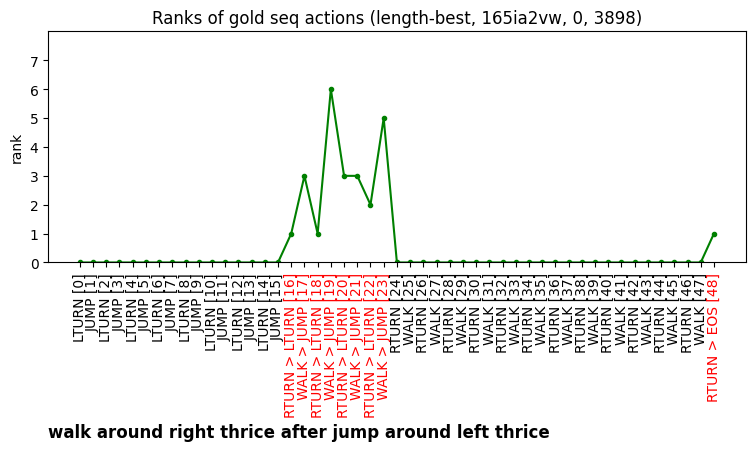

In [323]:
# sample_idx = 0
# sample_idx = 3000
sample_idx = 3898
commands, gold_actions = test_X[sample_idx], test_Y[sample_idx]

ranks, total_score, pred_actions = rank_gold_actions(encoder, decoder, commands, gold_actions)

print('  cmds', list(commands.view(1, -1)[0].cpu().numpy()))
print('gold_t', list(gold_actions.view(1, -1)[0].cpu().numpy()))
print('gold_p', pred_actions)
print(' ranks', ranks)

generate_image(commands, ranks, gold_actions, pred_actions, 'length-best', '165ia2vw', 0, sample_idx, None)

In [326]:
import os
import random

seed = 7
random.seed(seed)

def generate_images(kind, run, sample_frac):
    img_dir = f'images/search/{kind}/{run}'
    os.makedirs(img_dir, exist_ok=True)

    encoder, decoder = load_model(run)

    total_samples = int(len(test_X) * sample_frac)

    samples = []
    while len(samples) <= total_samples:
        sample_id = random.randint(0, len(test_X) - 1)

        if sample_id not in samples:
            commands, gold_actions = test_X[sample_id], test_Y[sample_id]

            ranks, total_score, pred_actions = rank_gold_actions(encoder, decoder, commands, gold_actions)
            gold_actions = list(gold_actions.view(1, -1)[0].cpu().numpy())

            if pred_actions != gold_actions:
                if len(samples) % 50 == 0:
                    print(f'progress: {len(samples)}/{total_samples}')
                samples.append(sample_id)
                generate_image(commands, ranks, gold_actions, pred_actions, kind, run, seed, sample_id, f'{img_dir}/{sample_id}.png')

In [327]:
generate_images('length-best', '165ia2vw', 0.1)

getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/165ia2vw
model: rnn_type=GRU, input_size=15, output_size=8, hidden_size=50, hiddel_layers=1,dropout=0.5, attention=True
progress: 0/392


/home/lukasm/code/Advanced-NLP-Paper-Implementation/venv/lib64/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


progress: 50/392
progress: 100/392
progress: 150/392
progress: 200/392
progress: 250/392
progress: 300/392
progress: 350/392


In [328]:
generate_images('length-best', '2kfyfqfm', 0.1)

getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/2kfyfqfm
model: rnn_type=GRU, input_size=15, output_size=8, hidden_size=50, hiddel_layers=1,dropout=0.5, attention=True
progress: 0/392


/home/lukasm/code/Advanced-NLP-Paper-Implementation/venv/lib64/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


progress: 50/392
progress: 100/392
progress: 150/392
progress: 200/392
progress: 250/392
progress: 300/392
progress: 350/392


In [329]:
generate_images('overall-best', '8l8heh1g', 0.1)

getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/8l8heh1g
model: rnn_type=LSTM, input_size=15, output_size=8, hidden_size=200, hiddel_layers=2,dropout=0.5, attention=False
progress: 0/392
progress: 50/392
progress: 100/392
progress: 150/392
progress: 200/392
progress: 250/392
progress: 300/392
progress: 350/392


In [330]:
generate_images('overall-best', 'biap89fa', 0.1)

getting model for run https://wandb.ai/project-group-1/Paper-Implemenation/runs/biap89fa
model: rnn_type=LSTM, input_size=15, output_size=8, hidden_size=200, hiddel_layers=2,dropout=0.5, attention=False
progress: 0/392
progress: 50/392
progress: 100/392
progress: 150/392
progress: 200/392
progress: 250/392
progress: 300/392
progress: 350/392
